In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("C:/Users/Rugved Chavan/Desktop/GAIP Project/Chest-Xray-Masks/data/Lung Segmentation/CXR_png")
mask_path = os.path.join("C:/Users/Rugved Chavan/Desktop/GAIP Project/Chest-Xray-Masks/data/Lung Segmentation","masks/")

C:\Users\Rugved Chavan\miniconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [3]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [4]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

    if flag == "train":
        for i in tqdm(training_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [5]:
#perform sanity check

def plotMask(X,y):
    sample = []

    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)


    for i in range(0,6,3):

        plt.figure(figsize=(25,10))

        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])

        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])


        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])

        plt.show()

In [6]:
# Load training and testing data
dim = 64*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:30<00:00,  4.48it/s]


training set


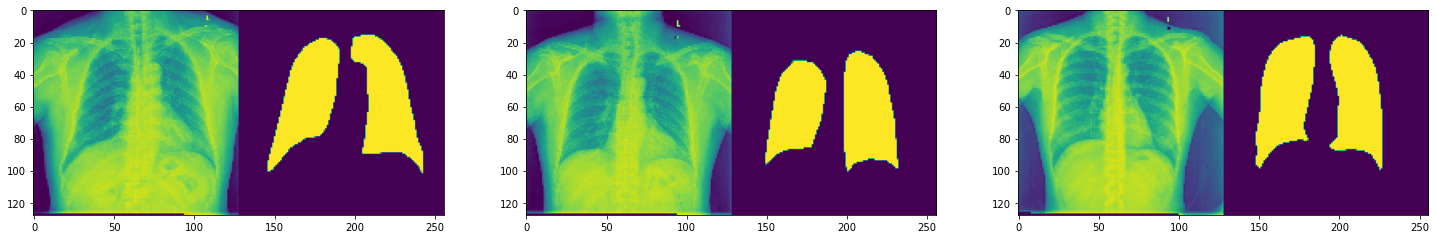

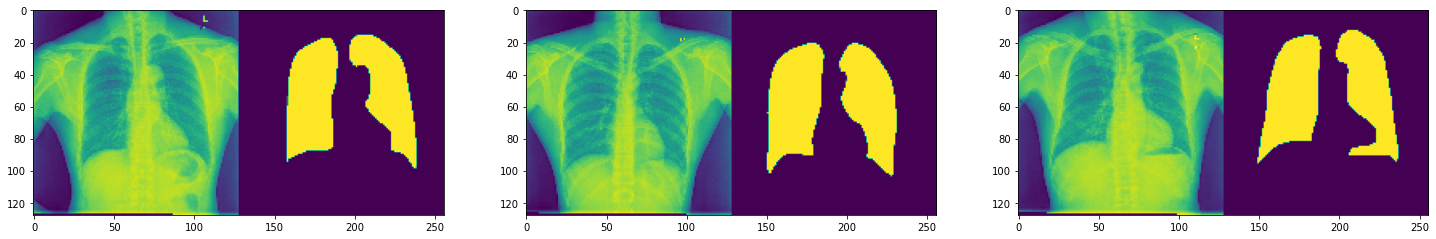

testing set


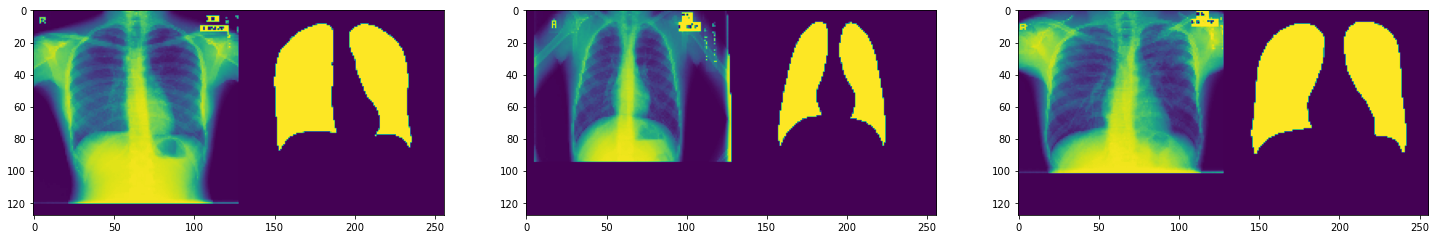

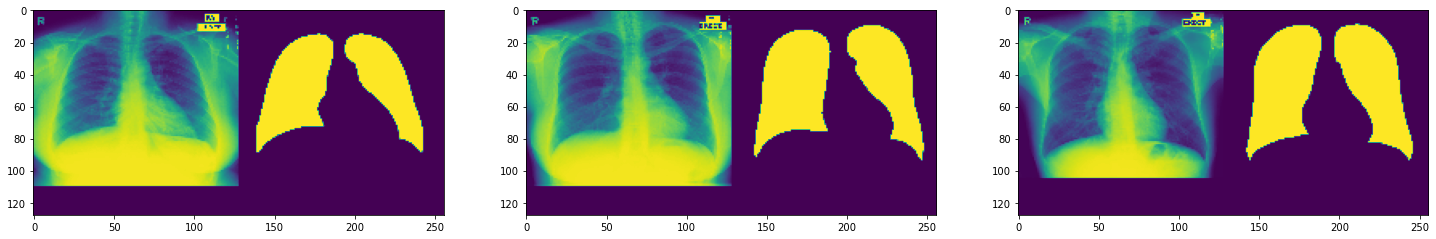

In [7]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [8]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [9]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    drop6 = Dropout(0.2)(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    drop8 = Dropout(0.2)(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(drop8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [10]:
model = unet(input_size=(128,128,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

C:\Users\Rugved Chavan\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [13]:
from IPython.display import clear_output
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0,
                                                            (mask>127).astype(np.float32),
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg,
                                                            test_size = 0.1,
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 100,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: -0.3840 - dice_coef: 0.3855 - binary_accuracy: 0.4602
Epoch 1: val_loss improved from inf to -0.48627, saving model to cxr_reg_weights.best.hdf5
36/36 [==============================] - 5s 101ms/step - loss: -0.3840 - dice_coef: 0.3855 - binary_accuracy: 0.4602 - val_loss: -0.4863 - val_dice_coef: 0.4863 - val_binary_accuracy: 0.5664 - lr: 2.0000e-04
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: -0.4090 - dice_coef: 0.4087 - binary_accuracy: 0.7429
Epoch 2: val_loss did not improve from -0.48627
36/36 [==============================] - 2s 52ms/step - loss: -0.4090 - dice_coef: 0.4087 - binary_accuracy: 0.7429 - val_loss: -0.3584 - val_dice_coef: 0.3584 - val_binary_accuracy: 0.8079 - lr: 2.0000e-04
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: -0.5531 - dice_coef: 0.5552 - binary_accuracy: 0.7035
Epoch 3: val_loss improved from -0.48627 to -0.70035, saving model to cxr_reg

In [14]:
model.save('Models/unet.h5')

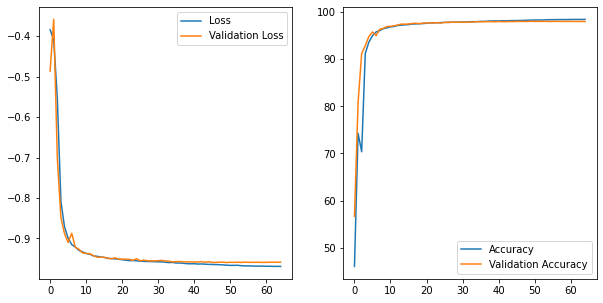

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-',
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [16]:
loss_history.history['dice_coef']

[0.3854822516441345,
 0.4086693227291107,
 0.5551680326461792,
 0.8088181018829346,
 0.8720133900642395,
 0.8995791673660278,
 0.9150440692901611,
 0.92103511095047,
 0.9296372532844543,
 0.9332430958747864,
 0.937310516834259,
 0.9390217661857605,
 0.9432909488677979,
 0.9441298246383667,
 0.9459201097488403,
 0.9469633102416992,
 0.949420690536499,
 0.9499474763870239,
 0.950598418712616,
 0.9512360095977783,
 0.9528809785842896,
 0.9539143443107605,
 0.954727053642273,
 0.9547832012176514,
 0.955484926700592,
 0.956349790096283,
 0.9567410945892334,
 0.9571033120155334,
 0.9571736454963684,
 0.957604169845581,
 0.9578065872192383,
 0.9579555988311768,
 0.9590334296226501,
 0.9594841003417969,
 0.9593176245689392,
 0.9609558582305908,
 0.9607961177825928,
 0.9615386128425598,
 0.9623264670372009,
 0.9626178741455078,
 0.9625208377838135,
 0.9634420871734619,
 0.9631350636482239,
 0.9637718200683594,
 0.9641595482826233,
 0.9643723964691162,
 0.9646515250205994,
 0.9650576114654541,
 

3/3 [==============================] - 2s 270ms/step


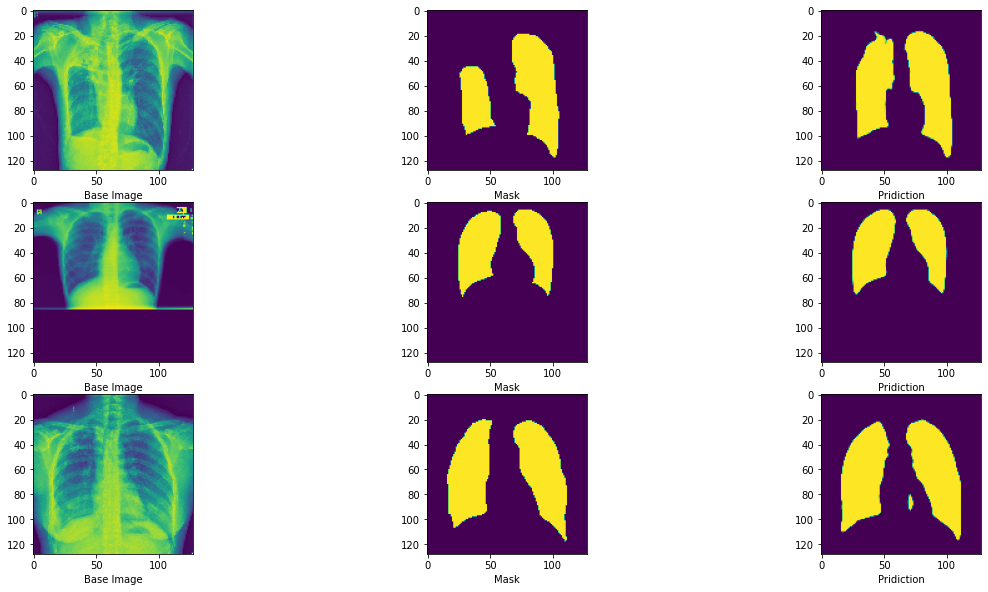

In [17]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)

    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")


    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")

    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")